# Basic data preprocessing 
### load raw files -> generate clips -> compute features-> aggregate into a matrix of features and scores
** Pandas version required to load pickle files is 0.20.1 or greater **

* Try classifying symptom presence from "typing", "walking" and "finger-to-nose" 

In [22]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt, resample
import time
import nolds
import re

from PreprocessFcns import *

%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [6]:
#---Pandas version required to load pickle files is 0.20.1 or greater---
pd.__version__

'0.22.0'

In [26]:
platform.release() == '10'

True

In [7]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'D:\CIS-PD Study\Subjects' #Windows remote path
        folder_path = r'D:\CIS-PD Study' #generic Windows repo path
        dict_path = 'D:\CIS-PD Study\Data_dict'
        scores_path = r'D:\CIS-PD Study\Scores' #remote repo
        features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
        
    elif platform.release() == '7':
        path = r'X:\CIS-PD Study\Subjects'
        folder_path = r'X:\CIS-PD Study'
#         dict_path = r'C:\Users\adai\Documents\Data_dict'
        dict_path = r'X:\CIS-PD Study\Data_dict'
        scores_path = r'X:\CIS-PD Study\Scores'
        features_path = r'X:\CIS-PD Study\FeatureMatrix'
    
else:
    path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
    folder_path = '/Volumes/RTO/CIS-PD Study/'
    dict_path = '../Data_dict' # Mac local path
    scores_path = '../Scores/' # Mac local path
    features_path = '../FeatureMatrix' # Mac local path


# #---------------------------------------------------------------------------------------------------------
# # Set path to folder containing Subject ID numbers
# # path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'D:\CIS-PD Study\Subjects' #Windows remote path
# #---------------------------------------------------------------------------------------------------------
# folder_path = r'D:\CIS-PD Study' #generic Windows repo path

# #Path where dictionary subject data is stored
# #dict_path = 'D:\CIS-PD Study\Data_dict_noErr' #remote repo
# dict_path = 'D:\CIS-PD Study\Data_dict'
# # dict_path = '../Data_dict' # Mac local path
# # dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'D:\CIS-PD Study\Scores' #remote repo
# # scores_path = '../Scores/' # Mac local path

# #path where feature matrix is saved
# features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
# # features_path = '../FeatureMatrix' # Mac local path
# # features_path = r'C:\Users\adai\Documents\FeatureMatrix' #Windows local path adai

In [8]:
complete = list(['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping',
           'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #3: Pronation-Supination',
           'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility',
           'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait',
           'MDS-UPDRS #8: Postural Stability', 'MDS-UPDRS #9: Postural Hand Tremor',
           'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Rest Tremor',
           'Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
           'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
           'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
           'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
           'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
           'Motor #12: Folding Towels', 'Motor #13: Sitting'])

complete_temp = complete
complete_temp.remove('MDS-UPDRS #11: Rest Tremor')


def process_annotations(path):
#---------------------------------------------------------------------------------------------------------
# Processes raw annotations file to extract start / end timestamps and remove unnecessary data
#
# Inputs:  path - filepath of the subject folder containing annotations.csv
#
# Outputs: df - dataframe containing list of activities and their start / end timestamps
#---------------------------------------------------------------------------------------------------------
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    del df['Value']
    
    df = df[(df.EventType != 'Testing Day')]
    
    sorter = set(df.EventType.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))
        
    df['EventType_Rank'] = df['EventType'].map(sorterIndex)
    df['Cycle'] = df.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['EventType_Rank']
    df[df['EventType'].str.contains('Heart')] = df[df['EventType'].str.contains('Heart')].replace(to_replace={'Cycle': {1: 'NaN', 2: 'NaN', 3: 'NaN', 4: 'NaN'}})
    df = df.reset_index(drop=True).set_index('EventType')
    
    return df

## Helper fcns

In [11]:
def extract_data(SubID, path):
#---------------------------------------------------------------------------------------------------------
# For a given subject, extracts and separates accelerometer, gyroscope, and EMG/ECG data into trials and sensor per activity
#
# Inputs: SubID - string of numbers corresponding to the subject ID
#         path - system path to corresponding subject's raw data files
#         sepFlag - 1 if want to reduce unimodal tasks' (finger to nose, pronation-supination, etc.) data in act_dict to
#                   only include active periods i.e right hand sensor excludes data when left hand is performing task
#                   Default value = 0, include all data for unimodal tasks
#
# Outputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                     accelerometer + gyroscope or accelerometer + EMG/ECG data. Every key within this dictionary is a dictionary
#---------------------------------------------------------------------------------------------------------
    timestamps = process_annotations(path)
    timestamps = fix_errors(SubID, timestamps)
    
    reverse_sensors_1024 = list(['anterior_thigh_left', 'anterior_thigh_right',
                                 'distal_lateral_shank_left', 'distal_lateral_shank_right'])
    # Hard coded list of sensors needed to be reversed in X- and Y- accel/gyro Day 1 data for Subject 1024
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith(('elec.csv', 'emg.csv', 'ecg.csv', 'ekg.csv')):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # Temporary fix for missing activities, added 10/10/2017 will remove once error functions are finished
    if SubID in ('1024', '1030', '1032'):
        complete_acts = complete_temp
    else:
        complete_acts = complete
                
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete_acts}

    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete_acts:
        
        startSize = timestamps.loc[activities, 'Start Timestamp (ms)']
        
        if np.size(startSize) == 1:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)']
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)']
        else:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, np.size(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, np.size(startTimestamp)):

            if np.size(startSize) == 1:
                startTime = startTimestamp
                endTime = endTimestamp
            else:
                startTime = startTimestamp[trials]
                endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]
                    
                    if SubID == '1024' and location in reverse_sensors_1024 and trials != (np.size(startTimestamp)-1):
                        data['accel'].loc[:, ('Accel X (g)')] = -1*data['accel'].loc[:, ('Accel X (g)')]
                        data['accel'].loc[:, ('Accel Y (g)')] = -1*data['accel'].loc[:, ('Accel Y (g)')]

                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]
                    
                    if SubID == '1024' and location in reverse_sensors_1024 and trials != (np.size(startTimestamp)-1):
                        data['gyro'].loc[:, ('Gyro X (°/s)')] = -1*data['gyro'].loc[:, ('Gyro X (°/s)')]
                        data['gyro'].loc[:, ('Gyro Y (°/s)')] = -1*data['gyro'].loc[:, ('Gyro Y (°/s)')]

                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]

                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict, timestamps


                                
def plot_data(acts, activity, trial, sensor, data, start=0, end=100000):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    toPlot = pd.DataFrame(acts[activity][trial]).loc[data, sensor][start:end].plot(figsize=(6,4))
    
    
def gen_unimodal_data(act_dict, side, unimodal_acts=None, shift=500):
#---------------------------------------------------------------------------------------------------------
# Reduces certain activities and subgroup of sensors in act_dict to only include data during active periods
# i.e right hand sensor excludes data when left hand is performing task (e.g. supination-pronation)
#
# Inputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                    accelerometer + gyroscope or accelerometer + EMG/ECG data
#         unimodal_acts - list of tasks to consider for data reduction, default value is None and uses list generated within
#                         function that cycles through all unimodal tasks. Can feed list to only look at specific subset
#         shift - shifting value of starting and ending index of reduced data. Default value is 50
#
# Outputs: act_dict - returns dictionary with appropriate tasks and sensors limited in scope to active data
                
    if unimodal_acts and unimodal_acts is not list:
        
        raise Error("unimodal_acts must be of type list")
        
    elif not unimodal_acts:
        unimodal_acts = list(['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements'])
      
    for acts in unimodal_acts:

        for trials in range(0, len(act_dict[acts].keys())):
            
            for sensors in act_dict[acts][trials].keys():
                
                for data in act_dict[acts][trials][sensors].keys():

                    index = len(act_dict[acts][trials][sensors][data]);
                    
                    if side == 'right':
                    
                        temp_data = act_dict[acts][trials][sensors][data][shift:index//2-shift];
                    
                    elif side == 'left':
                    
                        temp_data = act_dict[acts][trials][sensors][data][index//2+shift:index-shift];
                    
                    act_dict[acts][trials][sensors][data] = temp_data;
                    
    return act_dict

# Fix Error Functions

In [12]:
def fix_errors(participant, timestamps):
#input: 4 digit participant ID
# if debugFlag = 1, will execute merge function
#Output: ErrorList - A list of the errors needed to be fixed for the participant
#        timestamps - The dataFrame with the errors corrected for the participant
#        errordf - The dataFrame containing the remaining errors less the ones just fixed

    participant = int(participant) #convert to int, input SubID is a str
    errordf = pd.read_excel(os.path.join(folder_path, 'PD_errorWorkbook.xlsx'))
    errPar = errordf[errordf['Participant'] == participant]
    errorActivity = (errPar['Activity'])
    error = errPar['Error']
    cycle = errPar['Cycle']
    day = errPar['Day']
    time = errPar['Time Adjusted (sec)']
    desc = errPar['Type']
    errorAndActivity = errPar[['Error','Activity']]
    
    # Hard coded relabel for one activity in Subject 1049's timestamps
    if participant == 1049:
        for i in range(0,len(timestamps)-1):
            row = timestamps.iloc[i]
        
            if timestamps.index[i] == 'MDS-UPDRS #6: Arising from Chair' and row['Start Timestamp (ms)'] == 1505757980933:
                timestamps.reset_index(inplace=True)
                #timestamps.set_value(i, 'EventType', 'Motor #6: Sit to Stand')
                #.set_value is deprecated as of pandas 21.0, .at used instead for label-based
                timestamps.at[i, 'EventType'] = 'Motor #6: Sit to Stand'
                timestamps.set_index('EventType', inplace=True)
    
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        if errDay == 'Day 2':
            if 'MDS' in errAct:
                errCycle = errCycle + 2
            elif 'Motor' in errAct:
                errCycle = errCycle + 5

        if errType == 'Merge':
#             if debugFlag == 1:
#                 timestamps = fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
#             else:
#                 ; # do nothing
            timestamps = fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Late':
            timestamps = fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Early':
            timestamps = fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Duplicate':
            timestamps = fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay,participant)

        elif errType == 'Split':
            timestamps = fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
            
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        
        if errType == 'Absent':
            timestamps = fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
    
    
    tempappend = errordf.loc[errPar.index.values]
    #fixdf = fixdf.append(tempappend)
    errordf = errordf.drop(errPar.index.values)
    
    print('Subject ' + str(participant) + ' had ' + str(len(error)) + ' errors fixed.')

    return timestamps


def fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# subtracts time from the beginning or ending timestamp of the designated activity

    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
      
            if errType == 'End':
                startTime = startRow['Stop Timestamp (ms)']
                startTime = startTime - (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
        
            else:
                startTime = startRow['Start Timestamp (ms)']
                # print(startRow)
                # print(startTime)
                startTime = startTime - (errTime*1000)
                # print(errTime)
                # print(startTime)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
     
    return timestamps


def fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# adds time to the beginning or ending timestamp of the designated activity
    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
            
            if errType == 'End':
                startTime = startRow[1]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based

            else:
                startTime = startRow[0]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based

    return timestamps


def fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-2):
        nextRow = timestamps.iloc[i+1]
        startRow = timestamps.iloc[i]

        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            timeEnd = nextRow['Stop Timestamp (ms)']
            ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
            # timestamps.set_value(i,ii,timeEnd,takeable=True)
            timestamps.iat[i,ii] = timeEnd
            # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
            timestamps = pd.concat([timestamps.iloc[:(i+1)],timestamps.iloc[(i+2):]])

        timestamps.reset_index(inplace=True)
        timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
        timestamps.set_index('EventType',inplace=True)

    return timestamps

                

def fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timeStart1 = row['Start Timestamp (ms)']
            timeEnd2 = row['Stop Timestamp (ms)']
            timeChange = errTime
            timeEnd1 = timeStart1 + timeChange
            timeStart2 = timeEnd1
            idx = complete.index(errAct)
            ErrorActivity2 = complete[idx+1]
            ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
            # timestamps.set_value(i,ii,timeEnd1,takeable=True)
            timestamps.iat[i,ii] = timeEnd1
            # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
            line = pd.DataFrame({"Start Timestamp (ms)":timeEnd1,"Stop Timestamp (ms)":timeEnd2,"Cycle":errCycle},index=[ErrorActivity2])
            timestamps = pd.concat([timestamps.iloc[:(i+1)],line,timestamps.iloc[(i+1):]])
            
            timestamps.reset_index(inplace=True)
            colnames = timestamps.columns.tolist()
            colnames[colnames.index('index')] = 'EventType'
            timestamps.columns = colnames
            timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
            timestamps.set_index('EventType',inplace=True)
           
    return timestamps

            

def fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay,participant):

    for i in range(0,len(timestamps)-2):
        row = timestamps.iloc[i]
        if participant == 1054 and timestamps.index[i] == 'Motor #8: Typing on a Computer':
            if timestamps.index[i] == errAct and row['Cycle'] == errCycle+1:
                timestamps = pd.concat([timestamps.iloc[:(i)],timestamps.iloc[(i+1):]])
            
        elif timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timestamps = pd.concat([timestamps.iloc[:i],timestamps.iloc[(i+1):]])
            
    timestamps.reset_index(inplace=True)
    timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    timestamps.set_index('EventType',inplace=True)

    return timestamps

def fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
    
    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:

            for j in range(i-1,len(timestamps)-1):
                row = timestamps.iloc[j]
                
                if timestamps.index[j] == errAct:
                    cyclenum = row['Cycle']
                    newCycle = cyclenum + 1
                    ii = timestamps.columns.get_loc('Cycle')
                    # timestamps.set_value(j,ii,newCycle,takeable=True)
                    timestamps.iat[j,ii] = newCycle
                    # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
    
    return timestamps

In [14]:
errordf = pd.read_excel(os.path.join(folder_path, 'PD_errorWorkbook.xlsx'))
errordf.head()

,Participant,Activity,Cycle,Error,Day,Time Adjusted (sec),Type
0,1004,MDS-UPDRS #9: Postural Hand Tremor,1.0,Split,Day 1,5.0,NaN
1,1004,MDS-UPDRS #10: Kinetic Hand Tremor,1.0,Split Into,Day 1,NaN,NaN
2,1004,Motor #4: Finger to Nose,1.0,Merge,Day 1,NaN,NaN
3,1004,Motor #4: Finger to Nose,2.0,Merge,Day 1,NaN,NaN
4,1004,MDS-UPDRS #6: Arising from Chair,2.0,Absent,Day 1,NaN,Not tested


In [15]:
os.listdir(path + '/1020/anterior_thigh_left/d5la7wz0/')

['2017-08-03T17-44-51-148Z']

## Create dictionaries from sensor data from all the subjects

In [16]:
print(os.listdir(dict_path))
print(len(os.listdir(dict_path)))

[]
0


In [20]:
#all subj data files in repository
d = os.listdir(path)
f = [filename[0:4] for filename in d if filename.startswith('1')] #need to update to skip existing files in /data
print(f)
#existing data dictionary files
fd = os.listdir(dict_path)
fd = [x[:4] for x in fd] #ignore FX at end
print(list(set(f) - set(fd)))

#errors temporarily resolved 10/10/2017, will update later
# f.remove('1030')
# f.remove('1032')
# f.remove('1024')
# f.remove('1052')

['1004', '1016', '1018', '1019', '1020', '1024', '1029', '1030', '1032', '1038', '1044', '1046', '1047', '1049', '1051', '1052', '1053', '1054', '1055', '1056']
['1056']


In [21]:
#create data dict for remaining subjects
data_all = []
for SubID in list(set(f)-set(fd)):
    print('Loading Subject ' + SubID + ' Data...')
    act_dict, timestamps = extract_data(SubID, os.path.join(path, SubID))
    print('Extract data complete.')
    #save dict to Pickle file
    #filename = dict_path+'\\'+SubID + 'dict.pkl'
    filename = os.path.join(dict_path, SubID + 'dict.pkl')
    print(filename)
    f = open(filename,'wb')
    pickle.dump(act_dict,f)
    f.close()
    print(filename + ' ' + 'File Saved\n')

Loading Subject 1056 Data...
Subject 1056 had 8 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1056dict.pkl
D:\CIS-PD Study\Data_dict\1056dict.pkl File Saved



## Explore features from individual subject 

In [6]:
#load Pickle file dict
subj = 1047
#f = open(dict_path+'/'+str(subj)+'dict.pkl','rb')
f = open(os.path.join(dict_path, str(subj) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

In [10]:
#choose task, trials(visits) and sensor location
# task = 'Motor #8: Typing on a Computer'
task = 'Motor #5: Alternating Hand Movements'
# task = 'Motor #6: Sit to Stand'

# loc = 'dorsal_hand_left'
loc = 'dorsal_hand_right'
# loc = 'sacrum'
# loc = 'flexor_digitorum_left'
# loc = 'flexor_digitorum_right'
sensor = 'accel'
trial = 0

In [11]:
len(act_dict[task].keys())

7

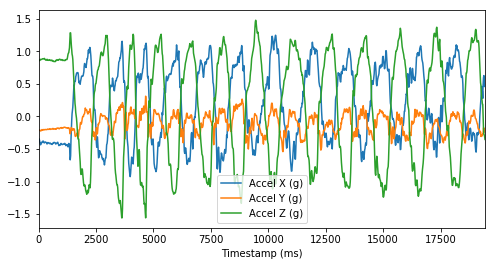

In [12]:
#activity dictionary structure (TASK-TRIAL-LOCATION-SENSOR)
rawdata = act_dict[task][trial][loc][sensor]
idx = rawdata.index
idx = idx-idx[0]
rawdata.index = idx
rawdata.plot(figsize=(8,4))

### Extract full recordings

In [13]:
#clipsize=0 extracts full recordings
clip_data = gen_clips(act_dict,task,loc,clipsize=0,verbose=True)
feature_extraction(clip_data)

Motor #5: Alternating Hand Movements  sensortype = accel - trial 0
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 0
Motor #5: Alternating Hand Movements  sensortype = accel - trial 1
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 1
Motor #5: Alternating Hand Movements  sensortype = accel - trial 2
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 2
Motor #5: Alternating Hand Movements  sensortype = accel - trial 3
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 3
Motor #5: Alternating Hand Movements  sensortype = accel - trial 4
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 4
Motor #5: Alternating Hand Movements  sensortype = accel - trial 5
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 5
Motor #5: Alternating Hand Movements  sensortype = accel - trial 6
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 6


In [14]:
clip_data[0]['accel']['features']

,RMSX,RMSY,RMSZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,varX,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,0.017231,0.005371,0.024527,2.173861,0.85243,3.038865,0.201327,-0.109309,0.157117,0.565602,...,0.027663,3.766287,13.442717,-0.001006,0.080136,0.318406,1.466696,0.400816,0.728046,0.242466


### or create clips 

In [15]:
clip_data = gen_clips(act_dict,task,loc,verbose=True,len_tol=0.95)
feature_extraction(clip_data)

Motor #5: Alternating Hand Movements  sensortype = accel - trial 0
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 0
Motor #5: Alternating Hand Movements  sensortype = accel - trial 1
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 1
Motor #5: Alternating Hand Movements  sensortype = accel - trial 2
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 2
Motor #5: Alternating Hand Movements  sensortype = accel - trial 3
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 3
Motor #5: Alternating Hand Movements  sensortype = accel - trial 4
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 4
Motor #5: Alternating Hand Movements  sensortype = accel - trial 5
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 5
Motor #5: Alternating Hand Movements  sensortype = accel - trial 6
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 6


## HP Filter raw accelerometer data

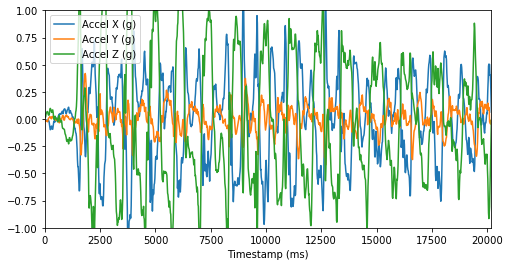

In [16]:
loc = 'dorsal_hand_left'
HPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

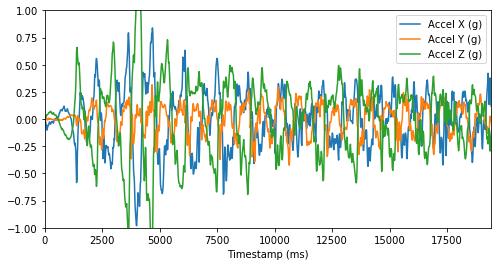

In [95]:
loc = 'dorsal_hand_right'
HPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

## BP filter (3-8 Hz) for tremor detection

In [ ]:
loc = 'dorsal_hand_left'
BPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

In [ ]:
loc = 'dorsal_hand_right'
BPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

## Clip extraction

In [18]:
clip_data = gen_clips(act_dict,task=task,clipsize=5000,location=loc,overlap=0,verbose=True,startTS=0,endTS=0.5)

Motor #5: Alternating Hand Movements  sensortype = accel - trial 0
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 0
Motor #5: Alternating Hand Movements  sensortype = accel - trial 1
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 1
Motor #5: Alternating Hand Movements  sensortype = accel - trial 2
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 2
Motor #5: Alternating Hand Movements  sensortype = accel - trial 3
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 3
Motor #5: Alternating Hand Movements  sensortype = accel - trial 4
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 4
Motor #5: Alternating Hand Movements  sensortype = accel - trial 5
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 5
Motor #5: Alternating Hand Movements  sensortype = accel - trial 6
Motor #5: Alternating Hand Movements  sensortype = gyro - trial 6


In [19]:
sensor

'accel'

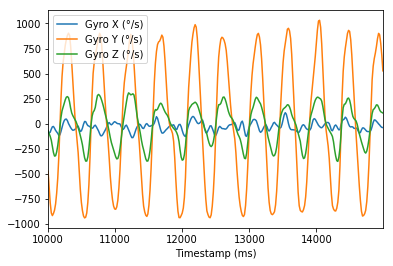

In [20]:
clip_data[1]['gyro']['data'][2].plot()

### Separate clips data for left and right limb

In [ ]:
clip_dataR = gen_clips(act_dict,task=task,clipsize=5000,location=loc,overlap=0,verbose=True,startTS=0,endTS=0.5)
clip_dataL = gen_clips(act_dict,task=task,clipsize=5000,location=loc,overlap=0,verbose=True,startTS=0.5,endTS=1)

In [ ]:
clip_dataL[1][sensor]['clip_len']

## Feature extraction

Let's start with the following:
* Energy (total within segment)
* Max
* Min
* Mean
* Variance
* Skewness
* Kurtosis
* Cross-correlation 
    * peak
    * Time lag of peak
* Sample Entropy
    * raw signal
    * Power spectra
* Power spectra 1-10 Hz

In [21]:
F = feature_extraction(clip_data)

In [23]:
F.head()

,RMSX,RMSY,RMSZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,varX,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,0.049746,0.008352,0.035888,2.808798,0.615999,1.965120,-0.031877,-0.003335,0.026018,0.879517,...,0.027757,3.547920,12.897847,0.000694,0.138063,0.064881,1.077479,0.471019,0.781070,0.335309
1,0.053210,0.008532,0.038704,3.238827,0.645928,2.081179,0.049315,-0.004629,-0.037209,0.938584,...,0.029493,2.934209,7.825487,-0.002005,0.148563,-0.058737,0.679564,0.460230,0.756718,0.286489
2,0.053634,0.008134,0.039454,3.082303,0.610473,2.207915,-0.040039,0.004689,0.030828,0.948039,...,0.043979,3.275432,9.739811,-0.000026,0.165718,-0.100350,0.362969,0.526878,0.962490,0.441134


In [22]:
clip_data[0]['accel']['features']

,RMSX,RMSY,RMSZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,varX,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,0.037832,0.005792,0.037272,2.295916,0.607195,1.904296,0.021430,-0.000530,-0.012665,0.668971,...,0.017876,2.877109,6.927840,0.002070,0.102842,-0.331303,0.850364,0.477352,0.951827,0.246520
1,0.039201,0.007169,0.037811,2.040644,0.631456,1.909585,-0.031142,-0.000924,0.026410,0.692830,...,0.016160,2.748287,5.912477,-0.000529,0.107326,-0.514023,2.133113,0.352224,0.906644,0.237818
2,0.038482,0.007132,0.035254,2.040078,0.607204,1.947810,-0.021131,0.000323,0.017145,0.680482,...,0.017432,3.485502,12.996642,-0.004748,0.104101,-0.819206,1.592096,0.385537,0.795638,0.270383
3,0.038874,0.006794,0.032145,2.093921,0.633272,1.735584,0.015220,0.002500,-0.023103,0.687576,...,0.013956,3.516546,13.637985,0.000956,0.087300,-1.018064,2.199893,0.319953,0.845974,0.188064
4,0.040070,0.007447,0.029386,2.297881,0.593311,1.755306,0.022135,0.001766,-0.013422,0.708573,...,0.016187,3.073478,10.319209,0.001022,0.085543,-0.886326,1.173700,0.433444,0.681603,0.280849
5,0.041133,0.007294,0.024285,2.345365,0.588484,1.396230,-0.044575,-0.008582,0.033210,0.726344,...,0.026155,3.683523,13.670606,0.001655,0.074412,-0.373394,0.645375,0.338489,0.680379,0.334104
6,0.034938,0.007453,0.023502,2.504531,0.951711,1.928443,0.030369,0.004294,-0.021278,0.617377,...,0.022137,3.250092,10.144883,0.000166,0.101670,-0.237672,10.933919,0.526143,0.763969,0.417081


In [ ]:
# clip_data[0][sensor]['features'].columns
# clip_data[0][sensor]['features']

In [ ]:
# #TEST FEATURE SET ON RAW DATA

# #Energy of signal on each axis
# E = np.asarray(np.sum(rawdata**2,axis=0))

# #range on each axis
# min_xyz = np.min(rawdata,axis=0)
# max_xyz = np.max(rawdata,axis=0)
# r = np.asarray(max_xyz-min_xyz)

# #Moments on each axis
# mean = np.asarray(np.mean(rawdata,axis=0))
# var = np.asarray(np.std(rawdata,axis=0))
# sk = skew(rawdata)
# kurt = kurtosis(rawdata)

# #Pearson correlation between axes pairs
# r_xy = pearsonr(rawdata['Accel X (g)'].values,rawdata['Accel Y (g)'].values)
# r_xy = np.asarray([r_xy[0]])
# r_xz = pearsonr(rawdata['Accel X (g)'].values,rawdata['Accel Z (g)'].values)
# r_xz = np.asarray([r_xz[0]])
# r_yz = pearsonr(rawdata['Accel Y (g)'].values,rawdata['Accel Z (g)'].values)
# r_yz = np.asarray([r_yz[0]])

# #Cross-correlation between axes pairs
# xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
# xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
# xcorr_peak_xy = np.max(xcorr_xy)
# xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy)

# xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
# xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
# xcorr_peak_xz = np.max(xcorr_xz)
# xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

# xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
# xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
# xcorr_peak_yz = np.max(xcorr_yz)
# xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

# #pack xcorr features
# xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
# xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])

# #sample entropy
# sH = []
# for a in range(3):
#     sH.append(nolds.sampen(rawdata.iloc[:,a]))
# # sh = np.asarray(sh)

# #Power of FFT between 1-10 Hz
# Pxx,fft_labels = powerspectra(rawdata,1,10) #dataframe with power spectra for each axis
# xfft = np.asarray([Pxx.iloc[:,0].values, Pxx.iloc[:,1].values, Pxx.iloc[:,2].values])
# xfft = np.reshape(xfft,(1,xfft.size)) #row vector
# xfft = xfft.reshape(-1)

# #Assemble features in array
# x = np.concatenate((E,r,mean,var,sk,kurt,r_xy,r_xz,r_yz,xcorr_peak,xcorr_lag,sH,xfft))
# x = x.reshape(1,x.shape[0])
# print(x.shape)


** Plot power spectra from one clip **

In [47]:
nb = 20 #number of bins for power spectra

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1104b7fd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x120f87940>], dtype=object)

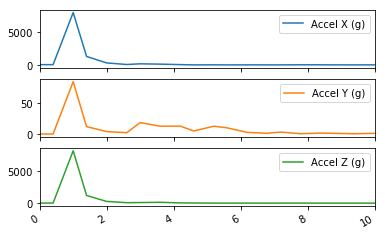

In [48]:
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
Pxx,fft_labels = powerspectra(rawdata,0,10,nbins=nb,binavg=True) #dataframe with power spectra for each axis
Pxx.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11044e390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12095d358>], dtype=object)

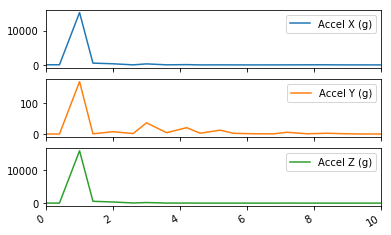

In [49]:
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
Pxx,fft_labels = powerspectra(rawdata,0,10,nbins=nb,binavg=False) #dataframe with power spectra for each axis
Pxx.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x120fafbe0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13c6ca518>], dtype=object)

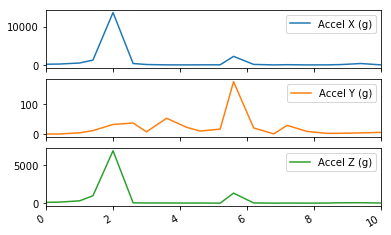

In [50]:
rawdata = clip_data[4][sensor]['data'][0] #trial-sensor-clip#
Pxx,fft_labels = powerspectra(rawdata,0,10,nbins=nb,binavg=False) #dataframe with power spectra for each axis
Pxx.plot(subplots=True)

## Compute Power spectra with Welch method

In [101]:
#PSD on magnitude using Welch method
def power_spectra_welch(rawdata,fm,fM):
    #compute PSD on signal magnitude
    rawdata['Accel_Mag']=np.sqrt((rawdata**2).sum(axis=1))
    x = rawdata.iloc[:,-1]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
    f,Pxx_den = welch(x,Fs,nperseg=min(256,n))
    #return PSD in desired interval of freq
    inds = (f<=fM)&(f>=fm)
    f=f[inds]
    Pxx_den=Pxx_den[inds]
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f,columns=['PSD_magnitude'])

    return Pxxdf


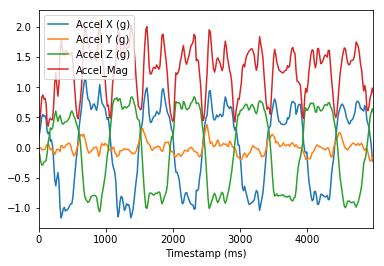

In [108]:
rawdata.plot()

In [105]:
Pxx = power_spectra_welch(rawdata,fm=0,fM=10)

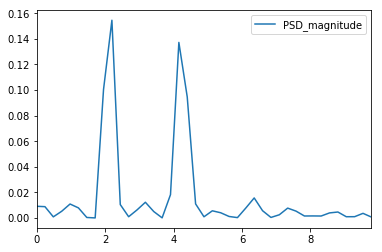

In [106]:
Pxx.plot()

In [125]:
np.nanmean(Pxx.values)

0.016449337380593749

In [109]:
domfreq = np.asarray([Pxx.iloc[:,-1].argmax()])
Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total

In [130]:
x = rawdata.iloc[:,1]
Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
print(Fs)

62.5801282051


In [131]:
sH_raw=[]
sH_raw.append(nolds.sampen(x)) #samp entr raw data


In [132]:
sH_raw

[0.95182746615094238]

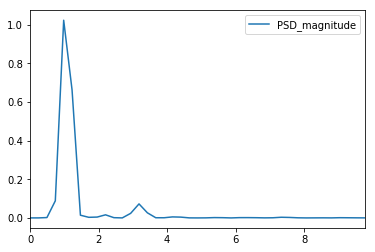

In [97]:
fm = 0; fM = 10
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
x = rawdata.iloc[:,-1]
n = len(x) #number of samples in clip
Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
f,Pxx_den = welch(x,Fs,nperseg=min(256,n))
#return PSD in desired interval of freq
inds = (f<=fM)&(f>=fm)
f=f[inds]
Pxx_den=Pxx_den[inds]
Pxxdf = pd.DataFrame(data=Pxx_den,index=f,columns=['PSD_magnitude'])
Pxxdf.plot()

In [99]:
Pxxdf.head()

,PSD_magnitude
0.000000,0.000070
0.244454,0.000116
0.488907,0.001885
0.733361,0.088543
0.977815,1.024027


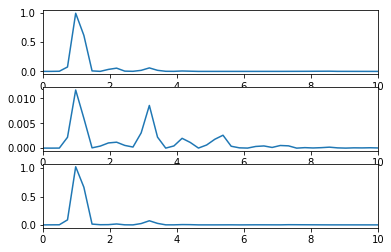

In [51]:
#signal features
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
fig = plt.figure()
# fp, ax_arr = plt.subplots(3, sharex=True)

for i in range(3):
    fig.add_subplot(3,1,i+1)
    x = rawdata.iloc[:,i]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
    f,Pxx_den = welch(x,Fs,nperseg=256)
    plt.plot(f,Pxx_den)
#     plt.semilogy(f,Pxx_den)
    plt.xlim([0,10])

In [ ]:
feature_extraction(clip_data)

In [ ]:
clip_data[1]['accel']['features']

In [52]:
clip_data.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

# Aggregate features data with scores for given task - cycle through all subjects
for s in subjects:
*    load score files
*    load subject file
*    choose task and sensor location
*    extract clips
*    compute features on each trial
*    Aggregate subj code and score with feature matrix

In [24]:
#aggreagate features (input) and metadata(output) for classification stage
#append is a flag on whether to create a new data matrix or aggregate new rows to existing one
#startTS and endTS specificies fraction of raw sensors data to use to generate clips
#side specificies which score side to use (recommended to use the same side of the loca)
#symptom specifies which filter to use. None only applies a HP filter to the data
def DataAggregator(tasks,task_scores_all,locs,clipsize=5000,overlap=0.5,startTS=0,endTS=1,append=1,symptom=None):
    
    t0=time.time()
    #load subject scores (std motor assessments)
    mot_scores = pd.read_excel(os.path.join(scores_path, 'MotorTasks.xls'))
    #fix error in original cols labels
    mot_scores.columns.values[75] = 'alternating left hand movements tremor right upper limb'
    #remove words:(Qxx) and 'rating' from each column for readability
    cols= mot_scores.columns
#     cols = cols[4:]
    cols = cols.tolist()
    colsnew = [x.split('(')[0] for x in cols]
    colsnew = [x.strip() for x in colsnew] #remove whitspace
    colsnew = [x.split('rating')[0] for x in colsnew]
    colsnew = [x.strip() for x in colsnew]
    colsnew = [x.lower() for x in colsnew] #make all lower case 
    colsnew = [x.replace('\x97',' ') for x in colsnew]    
    #simplify notation
    for i in range(len(colsnew)):
        x = colsnew[i]
        if x.find('finger to nose')>-1:
            colsnew[i] = x.replace(' hand','')
        if x.find('alternating')>-1:
            colsnew[i] = x.replace(' hand movements','')
    c = dict(zip(cols,colsnew))
    mot_scores = mot_scores.rename(index=str, columns=c)

    #load subjects features data and assemble with scores/subj metadata
    d = os.listdir(dict_path)
    fnames = [filename for filename in d if filename.startswith('1')]

    Data = pd.DataFrame() #the table with features and metadata
    
    #loop through subjects
    print(fnames)
    for subj_filename in fnames:

        #load current subject sensor data
        subj = int(subj_filename[:4]) #subj code
        f = open(os.path.join(dict_path,subj_filename),'rb')    
        act_dict = pickle.load(f)
        f.close()
        print('\nLoaded Subj %s sensor data'%subj)
        
        T = zip(tasks,task_scores_all) #make iterator

        #loop through tasks for current subject
        for task,task_scores in T: 
            
            print(task)
            ts = task_scores #copy variable

            #extract scores data for left and right side for current task
            for side in ['left','right']:
                
                #deal with exception for alternating and finger to nose (unilateral tasks)
                if (task_scores.find('alternating') > -1) | (task_scores.find('finger to nose') > -1):
                    task_scores=ts+ ' ' + side
                
                print('Aggregating scores for %s side'%side)
            
                #extract scores for corresponding task, subject and side
                subj_score = mot_scores.loc[mot_scores['subject']==subj,['subject','visit',
                                            task_scores+ ' ' + 'bradykinesia ' + side + ' upper limb',
                                            task_scores+ ' ' + 'tremor ' + side + ' upper limb']]
                #change 1 month label to 4 wks for proper sorting
                mot_scores.loc[mot_scores['visit']=='1 Month','visit']='4 Weeks'
                #rename cols
                subj_score = subj_score.rename(index=str,
                                               columns={subj_score.columns[2]:'Bradykinesia',subj_score.columns[3]:'Tremor'})
#                 print(subj_score.head())

                subj_score.index = range(len(subj_score))
                if len(subj_score) < 1:
                    print('no scores data for subject %d -- skipping..'%subj)

                #compute features from each sensor location and aggregate with metadata for current side
                else:             
                    
                    #loop through sensor locations and extract data - locations match the side
                    for loc in locs:
                        loc = loc+side                        
                        print(loc)

                        #high pass filter accelerometer data
                        HPfilter(act_dict,task,loc)

                        #generate clips and extract features for current task and sensor location
                        clip_data = gen_clips(act_dict,task,loc,clipsize,overlap,False,startTS,endTS)
                        feature_extraction(clip_data)

                        #aggreagate subject, scores and features data
                        n_visits = len(subj_score)    #of visits in Database
                        n_rec = len(clip_data.keys()) #of sensor recordings
                        print('n_visits in score file = %d, # recordings = %d, location: %s'%(n_visits,n_rec,loc))
                        N = n_visits

                        if n_visits != n_rec:
                            print('# of recordings does not match # of visits! - matching first %d recordings'%(min([n_visits,n_rec])))
                            N = min([n_visits,n_rec])

                        #aggregate data from each visit for current subject
                        for i in range(N):
                            #features
                            D = clip_data[i]['accel']['features']
                            featcols = D.columns.tolist()
                            #scores
                            D['Bradykinesia'] = subj_score['Bradykinesia'][i]
                            D['Tremor'] = subj_score['Tremor'][i]
                            #metadata
                            D['Visit'] = subj_score.visit[i] 
                            D['Task'] = task
                            D['Location'] = loc 
                            D['Subject'] = subj
                            Data = pd.concat([Data,D]) #concatenate data from each visit


    cols = ['Subject','Visit','Task','Location','Bradykinesia','Tremor']+ featcols
    Data = Data[cols]    
    print('\nData matrix generated')
    print(Data.shape)

    #save data to feature matrix
    if symptom == None:
        symptom=''
    saved_filename = 'Data'+symptom+'.csv'
    if append and os.path.isfile(os.path.join(features_path,saved_filename)):
        Data.to_csv(os.path.join(features_path,saved_filename),mode='a+',header=False) #append to existing
        print('Appending to existing Feature matrix ' + str(os.path.join(features_path,saved_filename)))    

    else:
        Data.to_csv(os.path.join(features_path,saved_filename))
        print('Feature matrix saved in ' + str(os.path.join(features_path,saved_filename)))
    
    t = time.time()
    eltime = (t-t0)/60
    print('Elapsed time = %.2f min'%eltime)

    #     return Data

In [25]:
tasks = ['Motor #2: Walking', 'Motor #3: Walking while Counting','Motor #5: Alternating Hand Movements',
         'Motor #6: Sit to Stand','Motor #7: Drawing on Paper','Motor #8: Typing on a Computer',
         'Motor #9: Nuts and Bolts','Motor #10: Drinking Water','Motor #11: Organizing Folder',
 'Motor #12: Folding Towels','Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']

task_scores = ['walking','walking while counting','alternating','sit to stand','drawing on a paper','typing on a computer keyboard',
              'assembling nuts and bolts','taking a glass of water and drinking',
              'organizing sheets in a folder','folding towels','finger to nose','alternating'] #name of task in scores sheet
locs = ['dorsal_hand_'] #sensor location

In [106]:
DataAggregator(tasks,task_scores,locs,append=0,symptom=None)

['1004dict.pkl', '1016dict.pkl', '1018dict.pkl', '1019dict.pkl', '1020dict.pkl', '1024dict.pkl', '1029dict.pkl', '1030dict.pkl', '1032dict.pkl', '1038dict.pkl', '1044dict.pkl', '1046dict.pkl', '1047dict.pkl', '1049dict.pkl', '1051dict.pkl', '1052dict.pkl']

Loaded Subj 1004 sensor data
Motor #2: Walking
Aggregating scores for left side
dorsal_hand_left
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_left
Aggregating scores for right side
dorsal_hand_right
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_right
Motor #3: Walking while Counting
Aggregating scores for left side
dorsal_hand_left
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_left
Aggregating scores for right side
dorsal_hand_right
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_right
Motor #5: Alternating Hand Movements
Aggregating scores for left side
dorsal_hand_left
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_left
Aggr

## Aggreagate scores with features from full recordings 

In [26]:
DataAggregator(tasks,task_scores,locs,clipsize=0,append=0,symptom='FullRec')

['1004dict.pkl', '1016dict.pkl', '1018dict.pkl', '1019dict.pkl', '1020dict.pkl', '1024dict.pkl', '1029dict.pkl', '1030dict.pkl', '1032dict.pkl', '1038dict.pkl', '1044dict.pkl', '1046dict.pkl', '1047dict.pkl', '1049dict.pkl', '1051dict.pkl', '1052dict.pkl']

Loaded Subj 1004 sensor data
Motor #2: Walking
Aggregating scores for left side
dorsal_hand_left
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_left
Aggregating scores for right side
dorsal_hand_right
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_right
Motor #3: Walking while Counting
Aggregating scores for left side
dorsal_hand_left
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_left
Aggregating scores for right side
dorsal_hand_right
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_right
Motor #5: Alternating Hand Movements
Aggregating scores for left side
dorsal_hand_left
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_left
Aggr

## Aggregate scores with raw clips data (to train CNN)

In [42]:
d = os.listdir(dict_path)
fnames = [filename for filename in d if filename.startswith('1')]
[fnames[13]]

['1049dict.pkl']

In [108]:
#aggreagate features (input) and metadata(output) for classification stage
#append is a flag on whether to create a new data matrix or aggregate new rows to existing one
#startTS and endTS specificies fraction of raw sensors data to use to generate clips
#side specificies which score side to use (recommended to use the same side of the loca)
#symptom specifies which filter to use. None only applies a HP filter to the data
def DataAggregator_rawdata(tasks,task_scores_all,locs,clipsize=5000,overlap=0.5,startTS=0,endTS=1,append=1,symptom=None):
    
    t0=time.time()
    #load subject scores (std motor assessments)
    mot_scores = pd.read_excel(os.path.join(scores_path, 'MotorTasks.xls'))
    #fix error in original cols labels
    mot_scores.columns.values[75] = 'alternating left hand movements tremor right upper limb'
    #remove words:(Qxx) and 'rating' from each column for readability
    cols= mot_scores.columns
#     cols = cols[4:]
    cols = cols.tolist()
    colsnew = [x.split('(')[0] for x in cols]
    colsnew = [x.strip() for x in colsnew] #remove whitspace
    colsnew = [x.split('rating')[0] for x in colsnew]
    colsnew = [x.strip() for x in colsnew]
    colsnew = [x.lower() for x in colsnew] #make all lower case 
    colsnew = [x.replace('\x97',' ') for x in colsnew]    
    #simplify notation
    for i in range(len(colsnew)):
        x = colsnew[i]
        if x.find('finger to nose')>-1:
            colsnew[i] = x.replace(' hand','')
        if x.find('alternating')>-1:
            colsnew[i] = x.replace(' hand movements','')
    c = dict(zip(cols,colsnew))
    mot_scores = mot_scores.rename(index=str, columns=c)

    #load subjects features data and assemble with scores/subj metadata
    d = os.listdir(dict_path)
    fnames = [filename for filename in d if filename.startswith('1')]
#     fnames=[fnames[13]]

    Data = pd.DataFrame() #the table with features and metadata
    
    #loop through subjects
    print(fnames)
    for subj_filename in fnames:

        #load current subject sensor data
        subj = int(subj_filename[:4]) #subj code
        f = open(os.path.join(dict_path,subj_filename),'rb')    
        act_dict = pickle.load(f)
        f.close()
        print('\nLoaded Subj %s sensor data'%subj)
        
        T = zip(tasks,task_scores_all) #make iterator

        #loop through tasks for current subject
        for task,task_scores in T: 
            
            print(task)
            ts = task_scores #copy variable

            #extract scores data for left and right side for current task
            for side in ['left','right']:
                
                #deal with exception for alternating and finger to nose (unilateral tasks)
                if (task_scores.find('alternating') > -1) | (task_scores.find('finger to nose') > -1):
                    task_scores=ts+ ' ' + side
                
                print('Aggregating scores for %s side'%side)
            
                #extract scores for corresponding task, subject and side
                subj_score = mot_scores.loc[mot_scores['subject']==subj,['subject','visit',
                                            task_scores+ ' ' + 'bradykinesia ' + side + ' upper limb',
                                            task_scores+ ' ' + 'tremor ' + side + ' upper limb',
                                            task_scores+ ' ' + 'dyskinesia ' + side + ' upper limb']]
                #change 1 month label to 4 wks for proper sorting
                mot_scores.loc[mot_scores['visit']=='1 Month','visit']='4 Weeks'
                #rename cols
                subj_score = subj_score.rename(index=str,
                                               columns={subj_score.columns[2]:'Bradykinesia',subj_score.columns[3]:'Tremor',
                                                        subj_score.columns[4]:'Dyskinesia'})
#                 print(subj_score.head())

                subj_score.index = range(len(subj_score))
                if len(subj_score) < 1:
                    print('no scores data for subject %d -- skipping..'%subj)

                #compute features from each sensor location and aggregate with metadata for current side
                else:             
                    
                    #loop through sensor locations and extract data - locations match the side
                    for loc in locs:
                        loc = loc+side                        
                        print(loc)

                        #high pass filter accelerometer data
#                         HPfilter(act_dict,task,loc)

                        #generate clips and extract features for current task and sensor location
                        clip_data = gen_clips(act_dict,task,loc,clipsize,overlap,False,startTS,endTS,len_tol=0.95)

                        #aggreagate subject, scores and features data
                        n_visits = len(subj_score)    #of visits in Database
                        n_rec = len(clip_data.keys()) #of sensor recordings
                        print('n_visits in score file = %d, # recordings = %d, location: %s'%(n_visits,n_rec,loc))
                        N = n_visits

                        if n_visits != n_rec:
                            print('# of recordings does not match # of visits! - matching first %d recordings'%(min([n_visits,n_rec])))
                            N = min([n_visits,n_rec])

                        #aggregate data from each visit (N visits) for current subject
                        for i in range(N):
                            #assemble raw data from each clip for current visit in rows of a dataframe
                            D = pd.DataFrame()
                            if list(clip_data[i].keys()):   #check at least one clip from current visit exist

                                for cc in range(len(clip_data[i]['accel']['data'])):
                                    acc=clip_data[i]['accel']['data'][cc].values
                                    if 'gyro' in clip_data[i].keys():
                                        gyr=clip_data[i]['gyro']['data'][cc].values
                                    else:
                                        gyr=np.empty(0) #create empty array if no gyro data (need to clean this)
                                    #need to assert that none is empty
                                    df = pd.DataFrame({'acc_xyz':[acc],'gyr_xyz':[gyr]},index=[cc])
                                    D = pd.concat((D,df))

                                featcols = D.columns.tolist()
                                #scores
                                D['Bradykinesia'] = subj_score['Bradykinesia'][i]
                                D['Tremor'] = subj_score['Tremor'][i]
                                D['Dyskinesia'] = subj_score['Dyskinesia'][i]
                                #metadata
                                D['Visit'] = subj_score.visit[i] 
                                D['Task'] = task
                                D['Location'] = loc 
                                D['Subject'] = subj
                                Data = pd.concat([Data,D]) #concatenate data from each visit


    cols = ['Subject','Visit','Task','Location','Bradykinesia','Tremor','Dyskinesia']+ featcols
    Data = Data[cols]    
    print('\nData matrix generated')
    print(Data.shape)

    #save data to feature matrix
    if symptom == None:
        symptom=''
    saved_filename = 'Data'+symptom+'.hdf5'
    if append and os.path.isfile(os.path.join(features_path,saved_filename)):
        Data.to_hdf(os.path.join(features_path,saved_filename),'a')#append to existing
        print('Appending to existing Feature matrix ' + str(os.path.join(features_path,saved_filename)))    

    else:
        Data.to_hdf(os.path.join(features_path,saved_filename),'w')
        print('Feature matrix saved in ' + str(os.path.join(features_path,saved_filename)))
    
    t = time.time()
    eltime = (t-t0)/60
    print('Elapsed time = %.2f min'%eltime)

    #     return Data

In [70]:
tasks = ['Motor #2: Walking', 'Motor #3: Walking while Counting','Motor #5: Alternating Hand Movements',
         'Motor #6: Sit to Stand','Motor #7: Drawing on Paper','Motor #8: Typing on a Computer',
         'Motor #9: Nuts and Bolts','Motor #10: Drinking Water','Motor #11: Organizing Folder',
 'Motor #12: Folding Towels','Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']

task_scores = ['walking','walking while counting','alternating','sit to stand','drawing on a paper','typing on a computer keyboard',
              'assembling nuts and bolts','taking a glass of water and drinking',
              'organizing sheets in a folder','folding towels','finger to nose','alternating'] #name of task in scores sheet

# locs = ['dorsal_hand_'] #sensor location
locs = ['dorsal_hand_','flexor_digitorum_','anterior_thigh_','distal_lateral_shank_'] #sensor location

In [59]:
# tasks = ['Motor #2: Walking']
# task_scores=['walking']
# locs = ['dorsal_hand_','flexor_digitorum_','anterior_thigh_','distal_lateral_shank_'] #sensor location

In [71]:
DataAggregator_rawdata(tasks,task_scores,locs,append=0,symptom='RawClipsUnfiltered_AllLocs')

['1004dict.pkl', '1016dict.pkl', '1018dict.pkl', '1019dict.pkl', '1020dict.pkl', '1024dict.pkl', '1029dict.pkl', '1030dict.pkl', '1032dict.pkl', '1038dict.pkl', '1044dict.pkl', '1046dict.pkl', '1047dict.pkl', '1049dict.pkl', '1051dict.pkl', '1052dict.pkl']

Loaded Subj 1004 sensor data
Motor #2: Walking
Aggregating scores for left side
dorsal_hand_left
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_left
flexor_digitorum_left
n_visits in score file = 7, # recordings = 7, location: flexor_digitorum_left
anterior_thigh_left
n_visits in score file = 7, # recordings = 7, location: anterior_thigh_left
distal_lateral_shank_left
n_visits in score file = 7, # recordings = 7, location: distal_lateral_shank_left
Aggregating scores for right side
dorsal_hand_right
n_visits in score file = 7, # recordings = 7, location: dorsal_hand_right
flexor_digitorum_right
n_visits in score file = 7, # recordings = 7, location: flexor_digitorum_right
anterior_thigh_right
n_visits in score f

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Visit', 'Task', 'Location', 'acc_xyz', 'gyr_xyz']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Feature matrix saved in ../FeatureMatrix/DataRawClipsUnfiltered_AllLocs.hdf5
Elapsed time = 13.69 min


In [109]:
hdftest =pd.read_hdf('../FeatureMatrix/DataRawClipsUnfiltered_AllLocs.hdf5')

In [110]:
hdftest.head()

,Subject,Visit,Task,Location,Bradykinesia,Tremor,Dyskinesia,acc_xyz,gyr_xyz
0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.386541542687, -0.98970016022, 0.2157625696...","[[2.41092545968, 28.7174792096, 1.80056458381]..."
1,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[-0.0355840390631, -1.08796826123, 0.47235828...","[[-54.4136720836, 12.9701686122, 110.688944839..."
2,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.232974746319, -0.885084306096, 0.553780422...","[[-45.2582589456, 7.66002899214, 38.7884336614..."
3,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.0929579613947, -1.03389028763, 0.497138933...","[[-10.7118333715, -65.6443121996, 15.411612115..."
4,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.0319218738079, -0.978469520104, 0.28888380...","[[62.3483634699, 23.9566643778, -94.8805981537..."


In [89]:
locs = hdftest.Location

In [102]:
hdftest[locs.str.find('left') > -1].Location.unique()

array(['dorsal_hand_left', 'flexor_digitorum_left', 'anterior_thigh_left',
       'distal_lateral_shank_left'], dtype=object)

### Modify data aggregator to concatenate data from all sensors from each side

In [19]:
#save corrected version of motor scores.xls 
mot_scores = pd.read_excel(os.path.join(scores_path, 'MotorTasks.xls'))
#fix error in original cols labels
mot_scores.columns.values[75] = 'alternating left hand movements tremor right upper limb'
#remove words:(Qxx) and 'rating' from each column for readability
cols= mot_scores.columns
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x.strip() for x in colsnew] #remove whitspace
colsnew = [x.split('rating')[0] for x in colsnew]
colsnew = [x.strip() for x in colsnew]
colsnew = [x.lower() for x in colsnew] #make all lower case 
colsnew = [x.replace('\x97',' ') for x in colsnew]    
#simplify notation
for i in range(len(colsnew)):
    x = colsnew[i]
    if x.find('finger to nose')>-1:
        colsnew[i] = x.replace(' hand','')
    if x.find('alternating')>-1:
        colsnew[i] = x.replace(' hand movements','')
c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)
mot_scores.to_excel(os.path.join(scores_path, 'Scores.xls')) #note that timestamps are not properly converted

In [10]:
#aggreagate metadata and rawdata from all sensor (accel,gyro) locations
#startTS and endTS specificies fraction of raw sensors data to use to generate clips
def DataAggregator_allLocs(tasks,task_scores_all,clipsize=5000,overlap=0,namesuffix=None,verbose=False):

# task_scores_all=task_scores
# clipsize=5000
# overlap=0
# verbose=False

    t0=time.time()
    #load subject scores (std motor assessments)
    mot_scores = pd.read_excel(os.path.join(scores_path, 'Scores.xls'))
    #change 1 month label to 4 wks for proper sorting (to incorporate in xls file)
    mot_scores.loc[mot_scores['visit']=='1 Month','visit']='4 Weeks'

    #load subjects features data and assemble with scores/subj metadata
    d = os.listdir(dict_path)
    fnames = [filename for filename in d if filename.startswith('1')]
#     fnames=[fnames[0]] #test only on 1st subject (TO DEBUG)

    clip_data = pd.DataFrame() #the table with features and metadata

    #loop through subjects
    print(fnames)
    for subj_filename in fnames:

        #load current subject sensor data
        subj = int(subj_filename[:4]) #subj code
        f = open(os.path.join(dict_path,subj_filename),'rb')    
        act_dict = pickle.load(f)
        f.close()
        print('\nLoaded Subj %s sensor data'%subj)

        T = zip(tasks,task_scores_all) #make iterator

        #loop through tasks for current subject
        for task,task_scores in T: 

            print(task)
            ts = task_scores #copy variable

            for side in ['left','right']:

                #****EXTRACT SCORES DATA FOR CURRENT TASK AND SIDE***
                #deal with exception for alternating and finger to nose (unilateral tasks)
                if (task_scores.find('alternating') > -1) | (task_scores.find('finger to nose') > -1):
                    task_scores=ts+ ' ' + side
                print('Aggregating scores for %s side'%side)
                #extract scores for corresponding task, subject and side
                subj_score = mot_scores.loc[mot_scores['subject']==subj,['subject','visit',
                                            task_scores+ ' ' + 'bradykinesia ' + side + ' upper limb',
                                            task_scores+ ' ' + 'tremor ' + side + ' upper limb',
                                            task_scores+ ' ' + 'dyskinesia ' + side + ' upper limb']]
                #rename cols
                subj_score = subj_score.rename(index=str,
                                               columns={subj_score.columns[2]:'Bradykinesia',subj_score.columns[3]:'Tremor',
                                                        subj_score.columns[4]:'Dyskinesia'})
                #reindex score table
                subj_score.index = range(len(subj_score))


    #                 print(subj_score.head())

                #Check that # of recordings and # of scored visits are equal
                Visits = act_dict[task].keys()
                n_rec = len(Visits) #of sensor recordings
                n_scores = len(subj_score)  #of visits in Database
                if n_scores != n_rec:
                    print('WARNING # of recordings does not match # of scored visits - matching first %d recs!'%min(n_scores,n_rec))
                    Visits = list(act_dict[task].keys())[0:min(n_scores,n_rec)]

                if len(subj_score) < 1:
                    print('no scores data for subject %d -- skipping..'%subj)
                    continue

                #****EXTRACT RAW CLIPS FROM ALL LOCATIONS FOR CURRENT VISIT+SIDE AND APPEND***
                for visit in Visits:
    #                 print(visit,subj_score.iloc[visit]['visit'])

                    clip_data_visit=pd.DataFrame() #storing all clips from current visit and side

                    locs = act_dict[task][visit].keys()
                    locs = [i for i in locs if (i.find(side)>0)] #choose senors on current side
                    locs.append('sacrum'); locs.append('medial_chest')

                    for location in locs:

                        for s in ['accel','gyro']:

                            if verbose:
                                print(task,' sensortype = %s - visit %d'%(s,visit))
                            #create clips and store in a list
                            rawdata = act_dict[task][visit][location][s]
                            if rawdata.empty is True: #skip if no data for current sensor
                                continue
                            #reindex time (relative to start)
                            idx = rawdata.index
                            idx = idx-idx[0]
                            rawdata.index = idx
                            #create clips data
                            deltat = np.median(np.diff(rawdata.index))
                            clips = pd.DataFrame()  
                            #take clips
                            location_name = re.sub(side, '', location) #column name dataframe (remove side info)
                            idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
                            for i in idx:
                                c = (rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]).copy()
                                #add time information to clips
                                c['Time']=(c.index.values/1000)-(c.index.values/1000)[0]
                                df = pd.DataFrame({location_name+'_'+s:[c.values]},index=[visit])
                                clips=pd.concat((clips,df)) #concatenate clips from current visit

                            nc = len(clips)
                            if (nc < clip_data_visit.shape[0]) & (clip_data_visit.empty is False):
                                print(visit,location+s,len(clips))
                                nd = clip_data_visit.shape[0]-nc
                                print('current sensor has less clips - adding %d empties'%nd)
                                clips=pd.concat((clips,pd.DataFrame({location_name+'_'+s:np.empty(nd)},
                                                                    index=[np.ones(nd)*visit])))
                            if (nc > clip_data_visit.shape[0]) & (clip_data_visit.empty is False):
                                print(visit,location+s,len(clips))
                                nd = nc-clip_data_visit.shape[0]
                                print('current sensor has more clips - discarding last %d clips'%nd)
                                clips = clips.iloc[:-nd]

                            clip_data_visit=pd.concat((clip_data_visit,clips),axis=1) #concatenate clips across locations

                    #concatenates metadata to all clips for current visit
                    clip_data_visit['Subject']=subj
                    clip_data_visit['Task']=task
                    clip_data_visit['Side']=side
                    clip_data_visit['Visit']=subj_score.iloc[visit]['visit']
                    #scores
                    clip_data_visit['Bradykinesia'] = subj_score['Bradykinesia'][visit]
                    clip_data_visit['Tremor'] = subj_score['Tremor'][visit]
                    clip_data_visit['Dyskinesia'] = subj_score['Dyskinesia'][visit]

                    clip_data = pd.concat((clip_data,clip_data_visit)) #concatenate clips across visits (index) 


    #SAVING DATA 
    metadata = ['Subject','Visit','Side','Task','Tremor','Bradykinesia','Dyskinesia']
    clip_data = clip_data[metadata+list(clip_data.columns[7:].values)]    
    print('\nClip Data matrix generated')
    print(clip_data.shape)

#     if namesuffix == None:
#         namesuffix=''
#     saved_filename = 'DataRaw_AllLocs'+namesuffix+'.hdf5'
#     clip_data.to_hdf(os.path.join(features_path,saved_filename),'w')
#     print('Data matrix saved in ' + str(os.path.join(features_path,saved_filename)))
#     t = time.time()
#     eltime = (t-t0)/60
#     print('Elapsed time = %.2f min'%eltime)

    return clip_data


In [11]:
tasks = ['Motor #2: Walking', 'Motor #3: Walking while Counting','Motor #6: Sit to Stand',
         'Motor #7: Drawing on Paper','Motor #8: Typing on a Computer','Motor #9: Nuts and Bolts',
         'Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']

task_scores = ['walking','walking while counting','sit to stand','drawing on a paper','typing on a computer keyboard',
              'assembling nuts and bolts','taking a glass of water and drinking',
              'organizing sheets in a folder','folding towels'] #name of task in scores sheet

In [12]:
data=DataAggregator_allLocs(tasks,task_scores,overlap=0.5,namesuffix='Overlap')

['1004dict.pkl', '1016dict.pkl', '1018dict.pkl', '1019dict.pkl', '1020dict.pkl', '1024dict.pkl', '1029dict.pkl', '1030dict.pkl', '1032dict.pkl', '1038dict.pkl', '1044dict.pkl', '1046dict.pkl', '1047dict.pkl', '1049dict.pkl', '1051dict.pkl', '1052dict.pkl']

Loaded Subj 1004 sensor data
Motor #2: Walking
Aggregating scores for left side
Aggregating scores for right side
Motor #3: Walking while Counting
Aggregating scores for left side
Aggregating scores for right side
Motor #6: Sit to Stand
Aggregating scores for left side
Aggregating scores for right side
Motor #7: Drawing on Paper
Aggregating scores for left side
Aggregating scores for right side
Motor #8: Typing on a Computer
Aggregating scores for left side
Aggregating scores for right side
Motor #9: Nuts and Bolts
Aggregating scores for left side
Aggregating scores for right side
Motor #10: Drinking Water
Aggregating scores for left side
Aggregating scores for right side
Motor #11: Organizing Folder
Aggregating scores for left side

In [18]:
data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,distal_lateral_shank__accel,distal_lateral_shank__gyro,dorsal_hand__accel,dorsal_hand__gyro,flexor_digitorum__accel,medial_chest_accel,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-1.02217135882, -0.316350041962, -0.11480888...","[[78.5229266804, -34.9431601434, -75.776302739...","[[-1.07173266194, -0.0989394979782, -0.1638818...","[[22.6138704509, -15.9609369039, 45.0751506828...","[[0.386541542687, -0.98970016022, 0.2157625696...","[[2.41092545968, 28.7174792096, 1.80056458381,...","[[-0.984817273213, 0.358464942397, -0.04388494...","[[-0.0233768215457, 0.919020370794, 0.16852063...","[[0.0693980315862, 1.01728847181, 0.0255741206...","[[-7.66002899214, -6.19516289006, 2.4719615472..."
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-1.46053253986, 0.636179140917, -0.013488975...","[[-121.797512779, -0.640878919661, -162.630655...","[[-0.393133440146, -0.628854810407, -0.2621499...","[[0.640878919661, -14.3739986267, 126.49729152...","[[-0.0355840390631, -1.08796826123, 0.47235828...","[[-54.4136720836, 12.9701686122, 110.688944839...","[[-0.803662165255, 0.248599984741, -0.19183642...","[[-0.0585336079957, 1.04841687648, 0.070862897...","[[0.0579232471199, 1.23921568627, 0.2966964217...","[[-5.64583810178, 17.9751277943, 9.36903944457..."


In [21]:
d = data.iloc[:,7:]

In [26]:
D = d.to_dict()
type(D)

dict

In [31]:
namesuffix='Overlap'
saved_filename = 'DataRaw_AllLocs'+namesuffix
filename = os.path.join(features_path,saved_filename)+'dict.pkl'
f = open(filename,'wb')
pickle.dump(D,f)
f.close()

In [38]:
# namesuffix='Overlap'
# saved_filename = 'DataRaw_AllLocs'+namesuffix+'.hdf5'
# data.to_hdf(os.path.join(features_path,saved_filename),'w')

In [39]:
!ls ../FeatureMatrix/

Data.csv                    DataRawClipsUnfiltered.hdf5
DataFullRec.csv             DataRaw_AllLocs.hdf5
DataRawClips.hdf5


In [43]:
data =pd.read_hdf('../FeatureMatrix/DataRaw_AllLocs.hdf5')

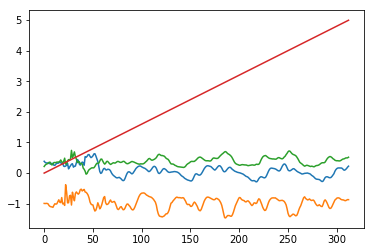

In [47]:
plt.plot(data['dorsal_hand__accel'].iloc[0]) #clip includes time vector

In [44]:
len(data)

14133

In [45]:
data.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,distal_lateral_shank__accel,distal_lateral_shank__gyro,dorsal_hand__accel,dorsal_hand__gyro,flexor_digitorum__accel,medial_chest_accel,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-1.02217135882, -0.316350041962, -0.11480888...","[[78.5229266804, -34.9431601434, -75.776302739...","[[-1.07173266194, -0.0989394979782, -0.1638818...","[[22.6138704509, -15.9609369039, 45.0751506828...","[[0.386541542687, -0.98970016022, 0.2157625696...","[[2.41092545968, 28.7174792096, 1.80056458381,...","[[-0.984817273213, 0.358464942397, -0.04388494...","[[-0.0233768215457, 0.919020370794, 0.16852063...","[[0.0693980315862, 1.01728847181, 0.0255741206...","[[-7.66002899214, -6.19516289006, 2.4719615472..."
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-1.35054551003, 0.570382238499, -0.359075303...","[[458.899824521, -81.5747310597, -65.339131761...","[[-1.4519874876, 2.19870298314, 0.66669718471,...","[[-29.388876173, 25.1773861295, 18.463416495, ...","[[0.232974746319, -0.885084306096, 0.553780422...","[[-45.2582589456, 7.66002899214, 38.7884336614...","[[-1.48433661402, 0.24811169604, -0.1469138628...","[[-0.0429083695735, 1.38777752346, 0.098695353...","[[0.0293583581292, 1.06916914626, 0.1643701838...","[[-2.47196154726, 31.2199588006, -18.097199969..."
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-0.896803234913, -0.0689097428855, 0.0149538...","[[86.3965819791, -15.5336842908, 109.285114824...","[[-0.948317692836, 0.0470588235294, -0.2741130...","[[-60.3952086671, -24.0177004654, 13.092240787...","[[0.0319218738079, -0.978469520104, 0.28888380...","[[62.3483634699, 23.9566643778, -94.8805981537...","[[-0.704539559014, 0.107972838941, -0.04437323...","[[-0.0209353780423, 0.596749828336, 0.11041428...","[[0.0786755168994, 0.689280537118, 0.116639963...","[[-5.34065766384, 4.66926070039, 21.2100404364..."
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-1.0276646067, -0.18463416495, -0.4997024490...","[[172.091248951, 60.0289921416, -97.0168612192...","[[-0.408880750744, -0.868970778973, -0.9992217...","[[403.112840467, -190.524147402, 33.3562218662...","[[-0.0824597543297, -1.03376821546, 0.40888075...","[[-22.003509575, 155.184252689, -32.0134279393...","[[-0.978957808804, 0.181704432746, -0.16400396...","[[-0.0761120012207, 1.04060425727, 0.071839475...","[[-0.1494773785, 1.06025787747, 0.108827344167...","[[3.87579156176, -106.477454795, -22.003509575..."
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[[-0.914503700313, -0.0543831540398, -0.044129...","[[20.8438239109, 9.49111161975, 98.1155107958,...","[[-0.916456855116, 0.179751277943, -0.25909819...","[[-31.5251392386, -14.8622873274, 8.5755703059...","[[-0.0994277866789, -0.903639276722, 0.3025558...","[[85.9082932784, 7.72106507973, -116.73151751,...","[[-0.876905470359, 0.203677424277, 0.003479056...","[[-0.104432745861, 0.790600442512, 0.160219729...","[[0.112245365072, 0.704051270314, 0.0195925841...","[[6.07309071489, 0.27466239414, 11.1390859846,..."


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: Mean of empty slice


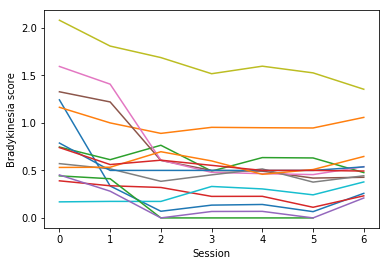

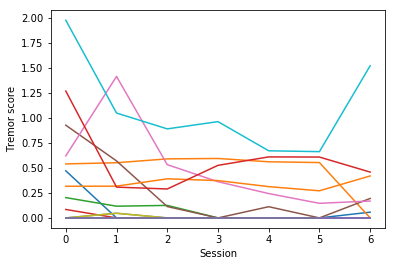

In [46]:
plt.figure()
for s in data.Subject.unique():
#     print(s,len(data[data.Subject==s].Visit.unique()))
    score = []
    for v in data.loc[data.Subject==s,'Visit'].unique():
        score.append(np.nanmean(data.loc[(data.Subject==s)&(data.Visit==v),'Bradykinesia'].values))
    
    plt.plot(score)

plt.xlabel('Session')
plt.ylabel('Bradykinesia score')

plt.figure()
for s in data.Subject.unique():
#     print(s,len(data[data.Subject==s].Visit.unique()))
    score = []
    for v in data.loc[data.Subject==s,'Visit'].unique():
        score.append(np.nanmean(data.loc[(data.Subject==s)&(data.Visit==v),'Tremor'].values))
    
    plt.plot(score)

plt.xlabel('Session')
plt.ylabel('Tremor score')
